### Fetch Data

In [ ]:
import cdsapi
client = cdsapi.Client()
pressurelevelfields = [
                        'u_component_of_wind',
                        'v_component_of_wind',
                        'geopotential',
                        'specific_humidity',
                        'temperature',
                        'vertical_velocity'
                    ]
client.retrieve(
    'reanalysis-era5-pressure-levels',
    {
        'product_type': 'reanalysis',
        'variable': pressurelevelfields,
        'grid': '1.0/1.0',
        # 'year': [2021, 2022, 2023],
        # 'month': [1 ],
        # 'day': [day],
        "date": "2021-01-01/2024-03-31",
        'time': ['06:00', '12:00', '18:00', '00:00'],
        'pressure_level': [1000],
        'format': 'netcdf'
    },
    f'actual-wind-speed-2021-2024.nc'
)


In [11]:
import xarray
import scipy

In [15]:
data = xarray.open_dataset(f'actual-wind-speed-2021-2024.nc', engine = "netcdf4", chunks={'time': 50})
ds_germany = data.where((data['latitude'] >= 47.3) & (data['latitude'] <= 55.0) & (data['longitude'] <= 15.0) & (data['longitude'] >= 5.9) & (data['expver'] == 1), drop=True)
# ds_germany = ds_germany.load()
ds_germany.to_netcdf(path="germany-wind-speed-2021-2024.nc")

### Actual Data

In [13]:
ds_germany = xarray.open_dataset(f'germany-wind-speed-2021-2024.nc', engine = "netcdf4")
df_germany = ds_germany.to_dataframe()
# germany = xarray.open_dataset(f'germany-wind-speed-2021-2024.nc', engine = "netcdf4")
df_germany['actual_wind_speed'] = (df_germany['u'] ** 2 + df_germany['v'] ** 2) ** (0.5)

In [14]:
df_actual = df_germany.reset_index()[['time', 'latitude', 'longitude', 'actual_wind_speed']]

### Prediction Data

In [22]:
import os
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from datetime import time

BASE_DIR = "/home/qnlzgl/graphcast/predictions/germany"
l = []
for i in tqdm(os.listdir(BASE_DIR)):
    curr_df = pd.read_csv(os.path.join(BASE_DIR, i))
    curr_df['base_date'] = i.split('.')[0]
    curr_df['base_date'] = pd.to_datetime(curr_df['base_date'])
    curr_df['predicted_wind_speed'] = (curr_df['u_component_of_wind'] ** 2 + curr_df['v_component_of_wind'] ** 2) ** (0.5)
    curr_df['fetch_date_time'] = curr_df['base_date'].apply(lambda x: pd.Timestamp(x.date()) + pd.Timedelta(hours=18))
    # curr_df['fetch_date_time'] = curr_df['base_date'].apply(lambda x: pd.Timestamp(x.date()) + pd.Timedelta(hours=24))
    # curr_df['fetch_date_time'] = curr_df['base_date'].apply(lambda x: pd.Timestamp(x.date()) + pd.Timedelta(hours=42))
    curr_df = curr_df[curr_df['fetch_date_time'] == curr_df['time']]
    l.append(curr_df)

100%|██████████| 1187/1187 [00:09<00:00, 119.95it/s]


In [2]:
df_prediction = pd.concat(l, axis=0)
df_prediction['time'] = pd.to_datetime(df_prediction['time'])

In [3]:
df_prediction.columns

Index(['time', 'lat', 'lon', 'batch', 'level', '10m_u_component_of_wind',
       '10m_v_component_of_wind', '2m_temperature', 'geopotential',
       'mean_sea_level_pressure', 'specific_humidity', 'temperature',
       'total_precipitation_6hr', 'u_component_of_wind', 'v_component_of_wind',
       'vertical_velocity', 'base_date', 'predicted_wind_speed',
       'fetch_date_time'],
      dtype='object')

In [4]:
df_prediction = df_prediction[['time', 'lat', 'lon', 'predicted_wind_speed', 'geopotential', 'temperature', 'specific_humidity']]

In [5]:
df_prediction.head(5)

,time,lat,lon,predicted_wind_speed,geopotential,temperature,specific_humidity
160,2023-12-16 06:00:00,48.0,6.0,2.399628,3413.5015,275.97977,0.004458
161,2023-12-16 06:00:00,48.0,7.0,0.903084,3414.7341,277.37180,0.004317
162,2023-12-16 06:00:00,48.0,8.0,0.846188,3427.9902,277.63068,0.004157
163,2023-12-16 06:00:00,48.0,9.0,0.226252,3422.5947,277.71613,0.004207
164,2023-12-16 06:00:00,48.0,10.0,0.452132,3414.5012,277.73975,0.004185


### Merge 

In [15]:
result = pd.merge(df_germany, df_prediction, how='left', left_on=['time', 'latitude', 'longitude'], right_on=['time', 'lat', 'lon'])

In [16]:
df_result = result[(~result['lat'].isna()) & (~result['actual_wind_speed'].isna())]
df_result.head(5)

,time,u,v,z,q,t,w,actual_wind_speed,lat,lon,predicted_wind_speed,geopotential,temperature,specific_humidity
320,2021-01-02 06:00:00,-1.219185,-2.895107,859.587036,0.004133,278.140839,-0.029887,3.141346,55.0,6.0,3.331606,931.10580,277.67343,0.004121
321,2021-01-02 06:00:00,-4.959403,-1.005148,858.024780,0.004403,276.432098,-0.029429,5.060237,55.0,7.0,3.827924,924.44860,276.98126,0.004066
322,2021-01-02 06:00:00,-5.308776,-2.155710,868.178589,0.003894,274.707855,0.020320,5.729764,55.0,8.0,4.003855,927.12700,275.73215,0.003891
323,2021-01-02 06:00:00,-3.584417,-2.010868,877.746704,0.003752,273.818115,0.080156,4.109943,55.0,9.0,2.622377,928.02496,273.71252,0.003710
324,2021-01-02 06:00:00,-1.990806,-1.957136,878.332397,0.003754,275.004425,0.006335,2.791718,55.0,10.0,2.096983,928.80840,274.16687,0.003757


In [17]:
df_result = df_result.rename(columns={
    "z": "actual_geopotential",
    "q": "actual_specific_humidity",
    "t": "actual_temperature",
    "geopotential": "predicted_geopotential",
    "temperature": "predicted_temperature",
    "specific_humidity": "predicted_specific_humidity"
}).drop(['u', 'v', 'w'], axis=1)
df_result.head(5)

,time,actual_geopotential,actual_specific_humidity,actual_temperature,actual_wind_speed,lat,lon,predicted_wind_speed,predicted_geopotential,predicted_temperature,predicted_specific_humidity
320,2021-01-02 06:00:00,859.587036,0.004133,278.140839,3.141346,55.0,6.0,3.331606,931.10580,277.67343,0.004121
321,2021-01-02 06:00:00,858.024780,0.004403,276.432098,5.060237,55.0,7.0,3.827924,924.44860,276.98126,0.004066
322,2021-01-02 06:00:00,868.178589,0.003894,274.707855,5.729764,55.0,8.0,4.003855,927.12700,275.73215,0.003891
323,2021-01-02 06:00:00,877.746704,0.003752,273.818115,4.109943,55.0,9.0,2.622377,928.02496,273.71252,0.003710
324,2021-01-02 06:00:00,878.332397,0.003754,275.004425,2.791718,55.0,10.0,2.096983,928.80840,274.16687,0.003757


In [18]:
# df_result['error'] = (df_result['actual_wind_speed'] **2 + df_result['predicted_wind_speed']**2)**0.5
# df_result['error'].mean()

### Wind Speed

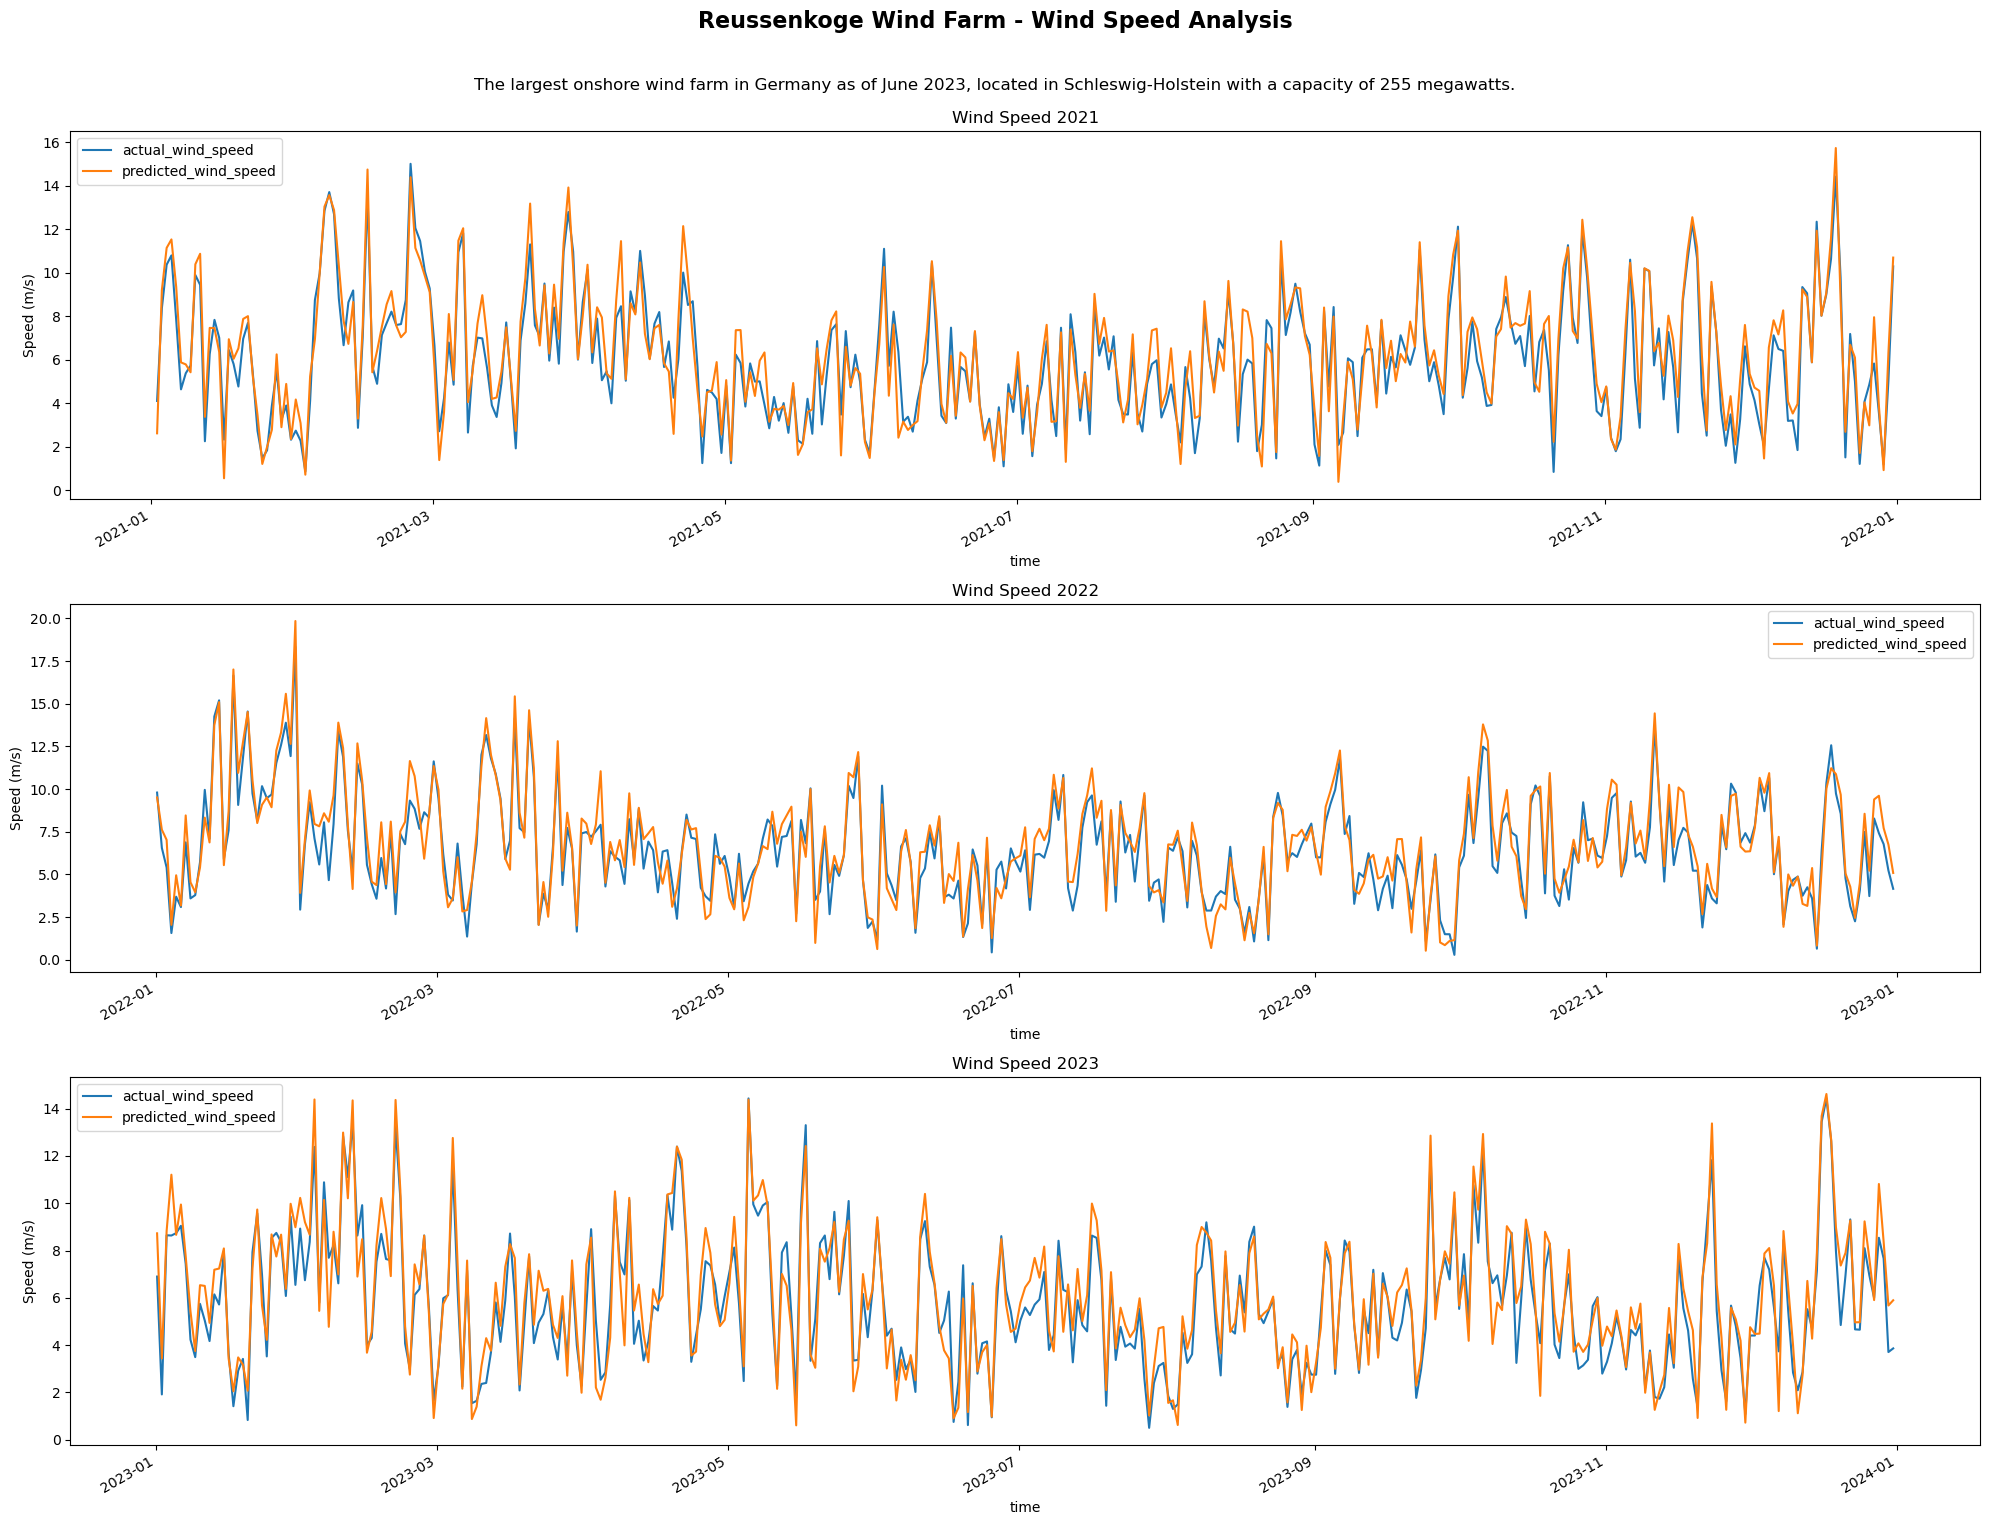

In [19]:
import matplotlib.pyplot as plt

# Set up a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 16))  # Increased height to accommodate the title block

# Add a main title with information about the wind farm
fig.suptitle('Reussenkoge Wind Farm - Wind Speed Analysis', fontsize=16, fontweight='bold')
plt.figtext(0.5, 0.93, 'The largest onshore wind farm in Germany as of June 2023, located in Schleswig-Holstein with a capacity of 255 megawatts.',
            ha='center', fontsize=12)

# First subplot for 2021
df1 = df_result.query('lat == 55 & lon == 9 & time >= "2021-01-01" & time < "2022-01-01"')
df1_grouped = df1.groupby('time').agg({
    'actual_wind_speed': 'mean',
    'predicted_wind_speed': 'mean'
})
df1_grouped.plot(ax=axs[0], title='Wind Speed 2021')
axs[0].set_ylabel('Speed (m/s)')

# Second subplot for 2022
df2 = df_result.query('lat == 55 & lon == 9 & time >= "2022-01-01" & time < "2023-01-01"')
df2_grouped = df2.groupby('time').agg({
    'actual_wind_speed': 'mean',
    'predicted_wind_speed': 'mean'
})
df2_grouped.plot(ax=axs[1], title='Wind Speed 2022')
axs[1].set_ylabel('Speed (m/s)')

# Third subplot for 2023
df3 = df_result.query('lat == 55 & lon == 9 & time >= "2023-01-01" & time < "2024-01-01"')
df3_grouped = df3.groupby('time').agg({
    'actual_wind_speed': 'mean',
    'predicted_wind_speed': 'mean'
})
df3_grouped.plot(ax=axs[2], title='Wind Speed 2023')
axs[2].set_ylabel('Speed (m/s)')

# Adjust layout to accommodate the main title and subtitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()

### Temperature

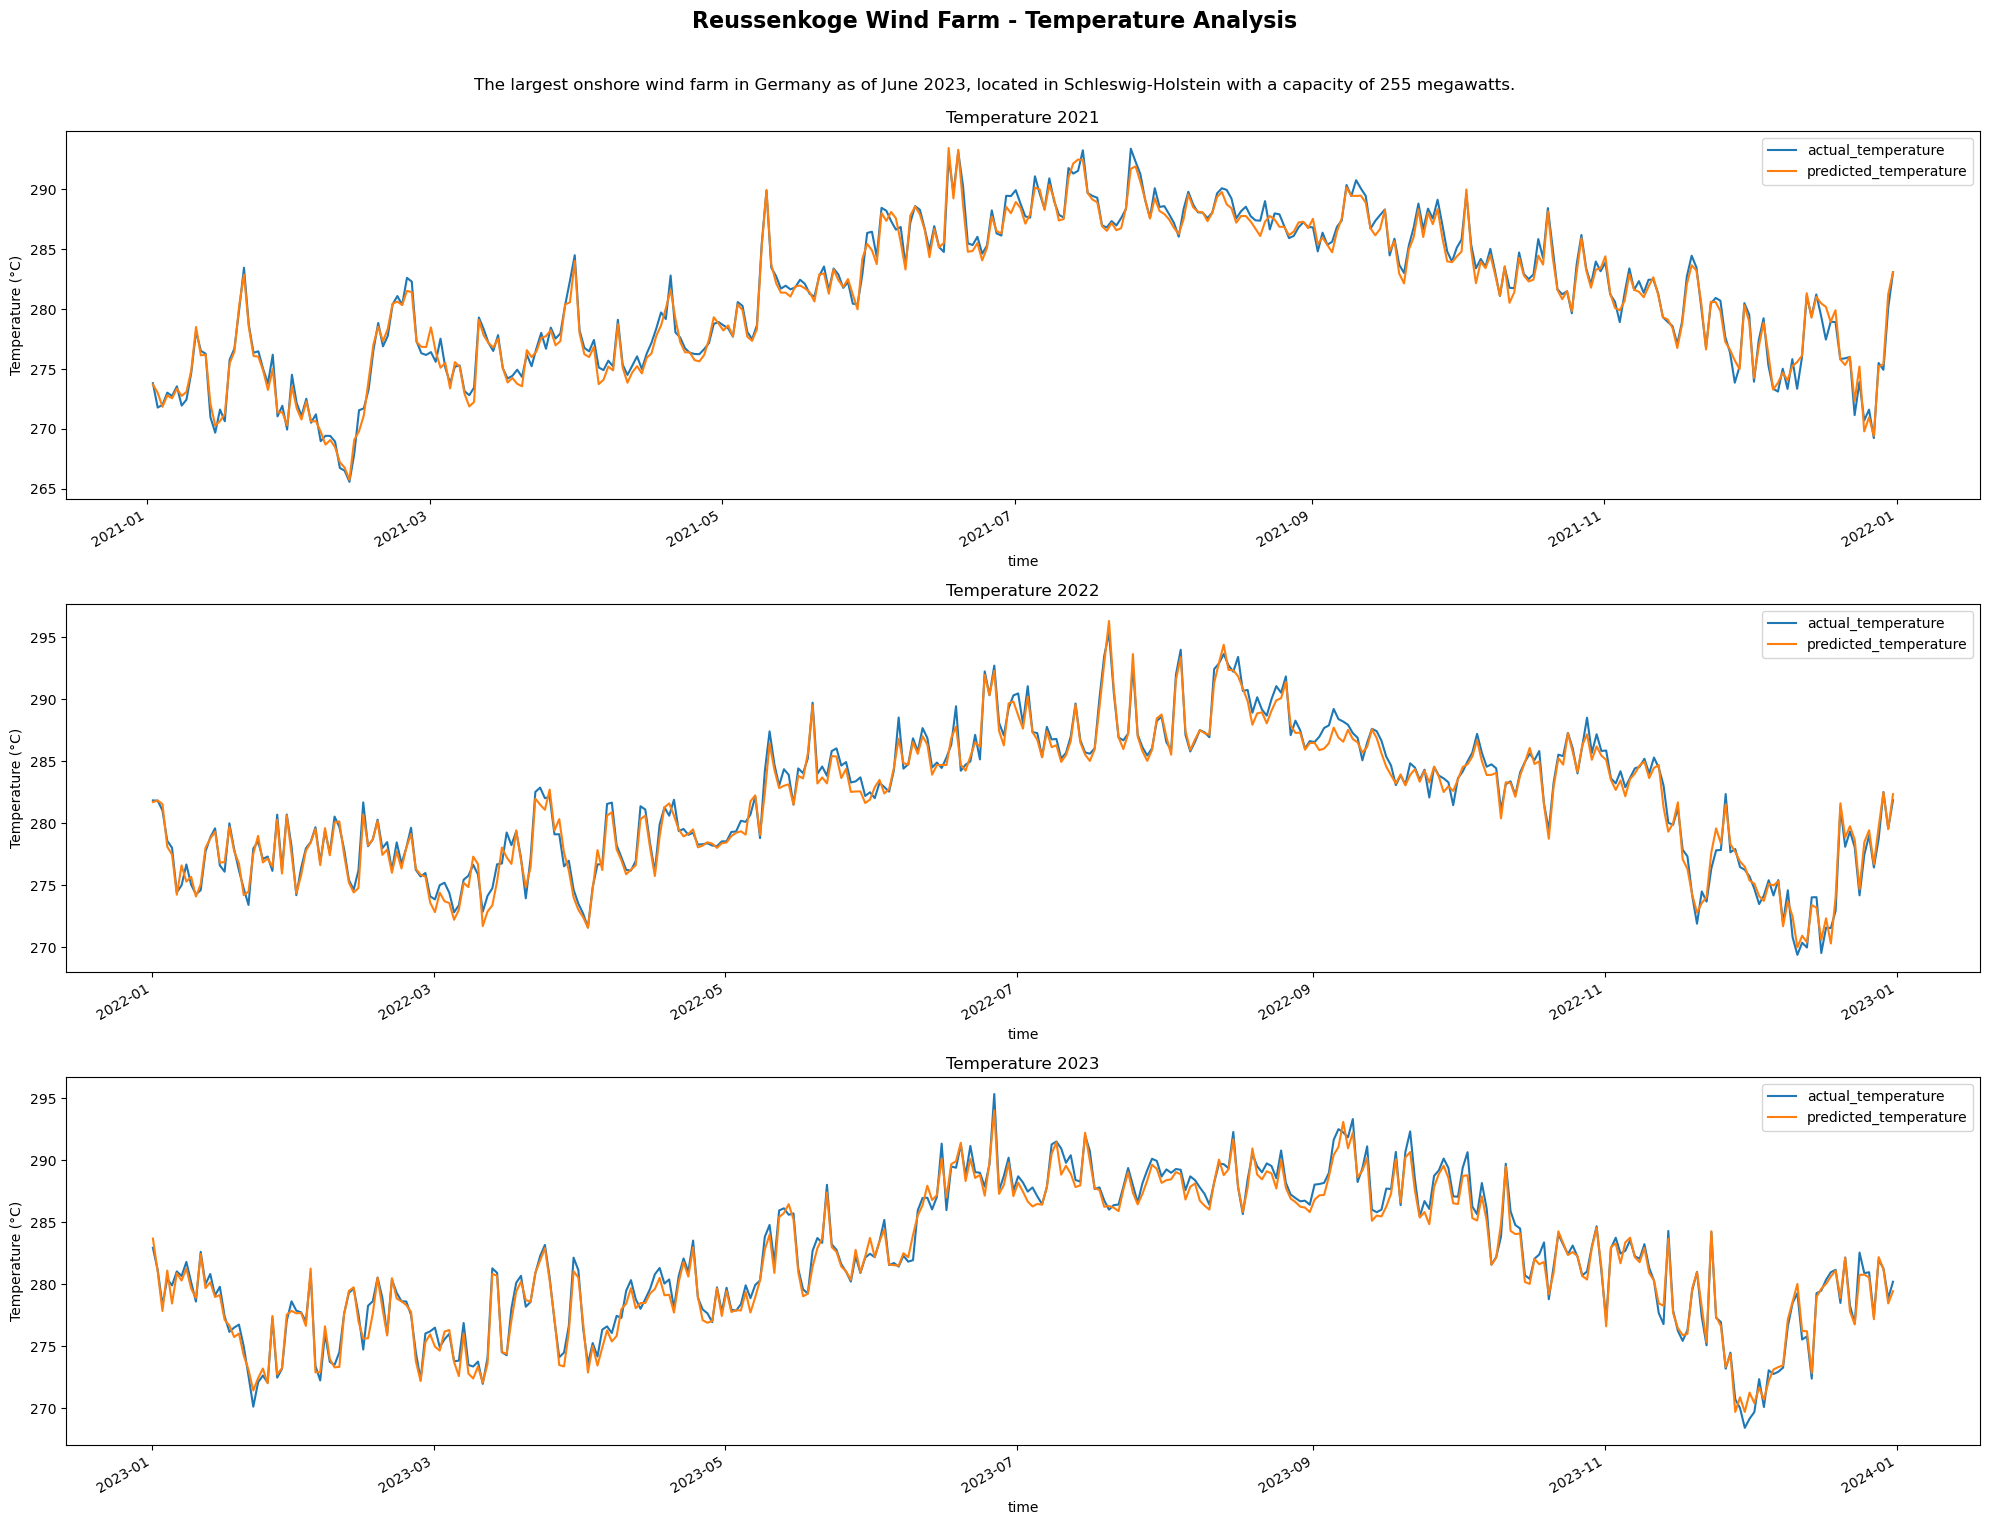

In [20]:
import matplotlib.pyplot as plt

# Set up a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 16))  # Increased height to accommodate the title block

# Add a main title with information about the wind farm
fig.suptitle('Reussenkoge Wind Farm - Temperature Analysis', fontsize=16, fontweight='bold')
plt.figtext(0.5, 0.93, 'The largest onshore wind farm in Germany as of June 2023, located in Schleswig-Holstein with a capacity of 255 megawatts.',
            ha='center', fontsize=12)

# First subplot for 2021 temperature
df1 = df_result.query('lat == 55 & lon == 9 & time >= "2021-01-01" & time < "2022-01-01"')
df1_grouped = df1.groupby('time').agg({
    'actual_temperature': 'mean',
    'predicted_temperature': 'mean'
})
df1_grouped.plot(ax=axs[0], title='Temperature 2021')
axs[0].set_ylabel('Temperature (°C)')

# Second subplot for 2022 temperature
df2 = df_result.query('lat == 55 & lon == 9 & time >= "2022-01-01" & time < "2023-01-01"')
df2_grouped = df2.groupby('time').agg({
    'actual_temperature': 'mean',
    'predicted_temperature': 'mean'
})
df2_grouped.plot(ax=axs[1], title='Temperature 2022')
axs[1].set_ylabel('Temperature (°C)')

# Third subplot for 2023 temperature
df3 = df_result.query('lat == 55 & lon == 9 & time >= "2023-01-01" & time < "2024-01-01"')
df3_grouped = df3.groupby('time').agg({
    'actual_temperature': 'mean',
    'predicted_temperature': 'mean'
})
df3_grouped.plot(ax=axs[2], title='Temperature 2023')
axs[2].set_ylabel('Temperature (°C)')

# Adjust layout to accommodate the main title and subtitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


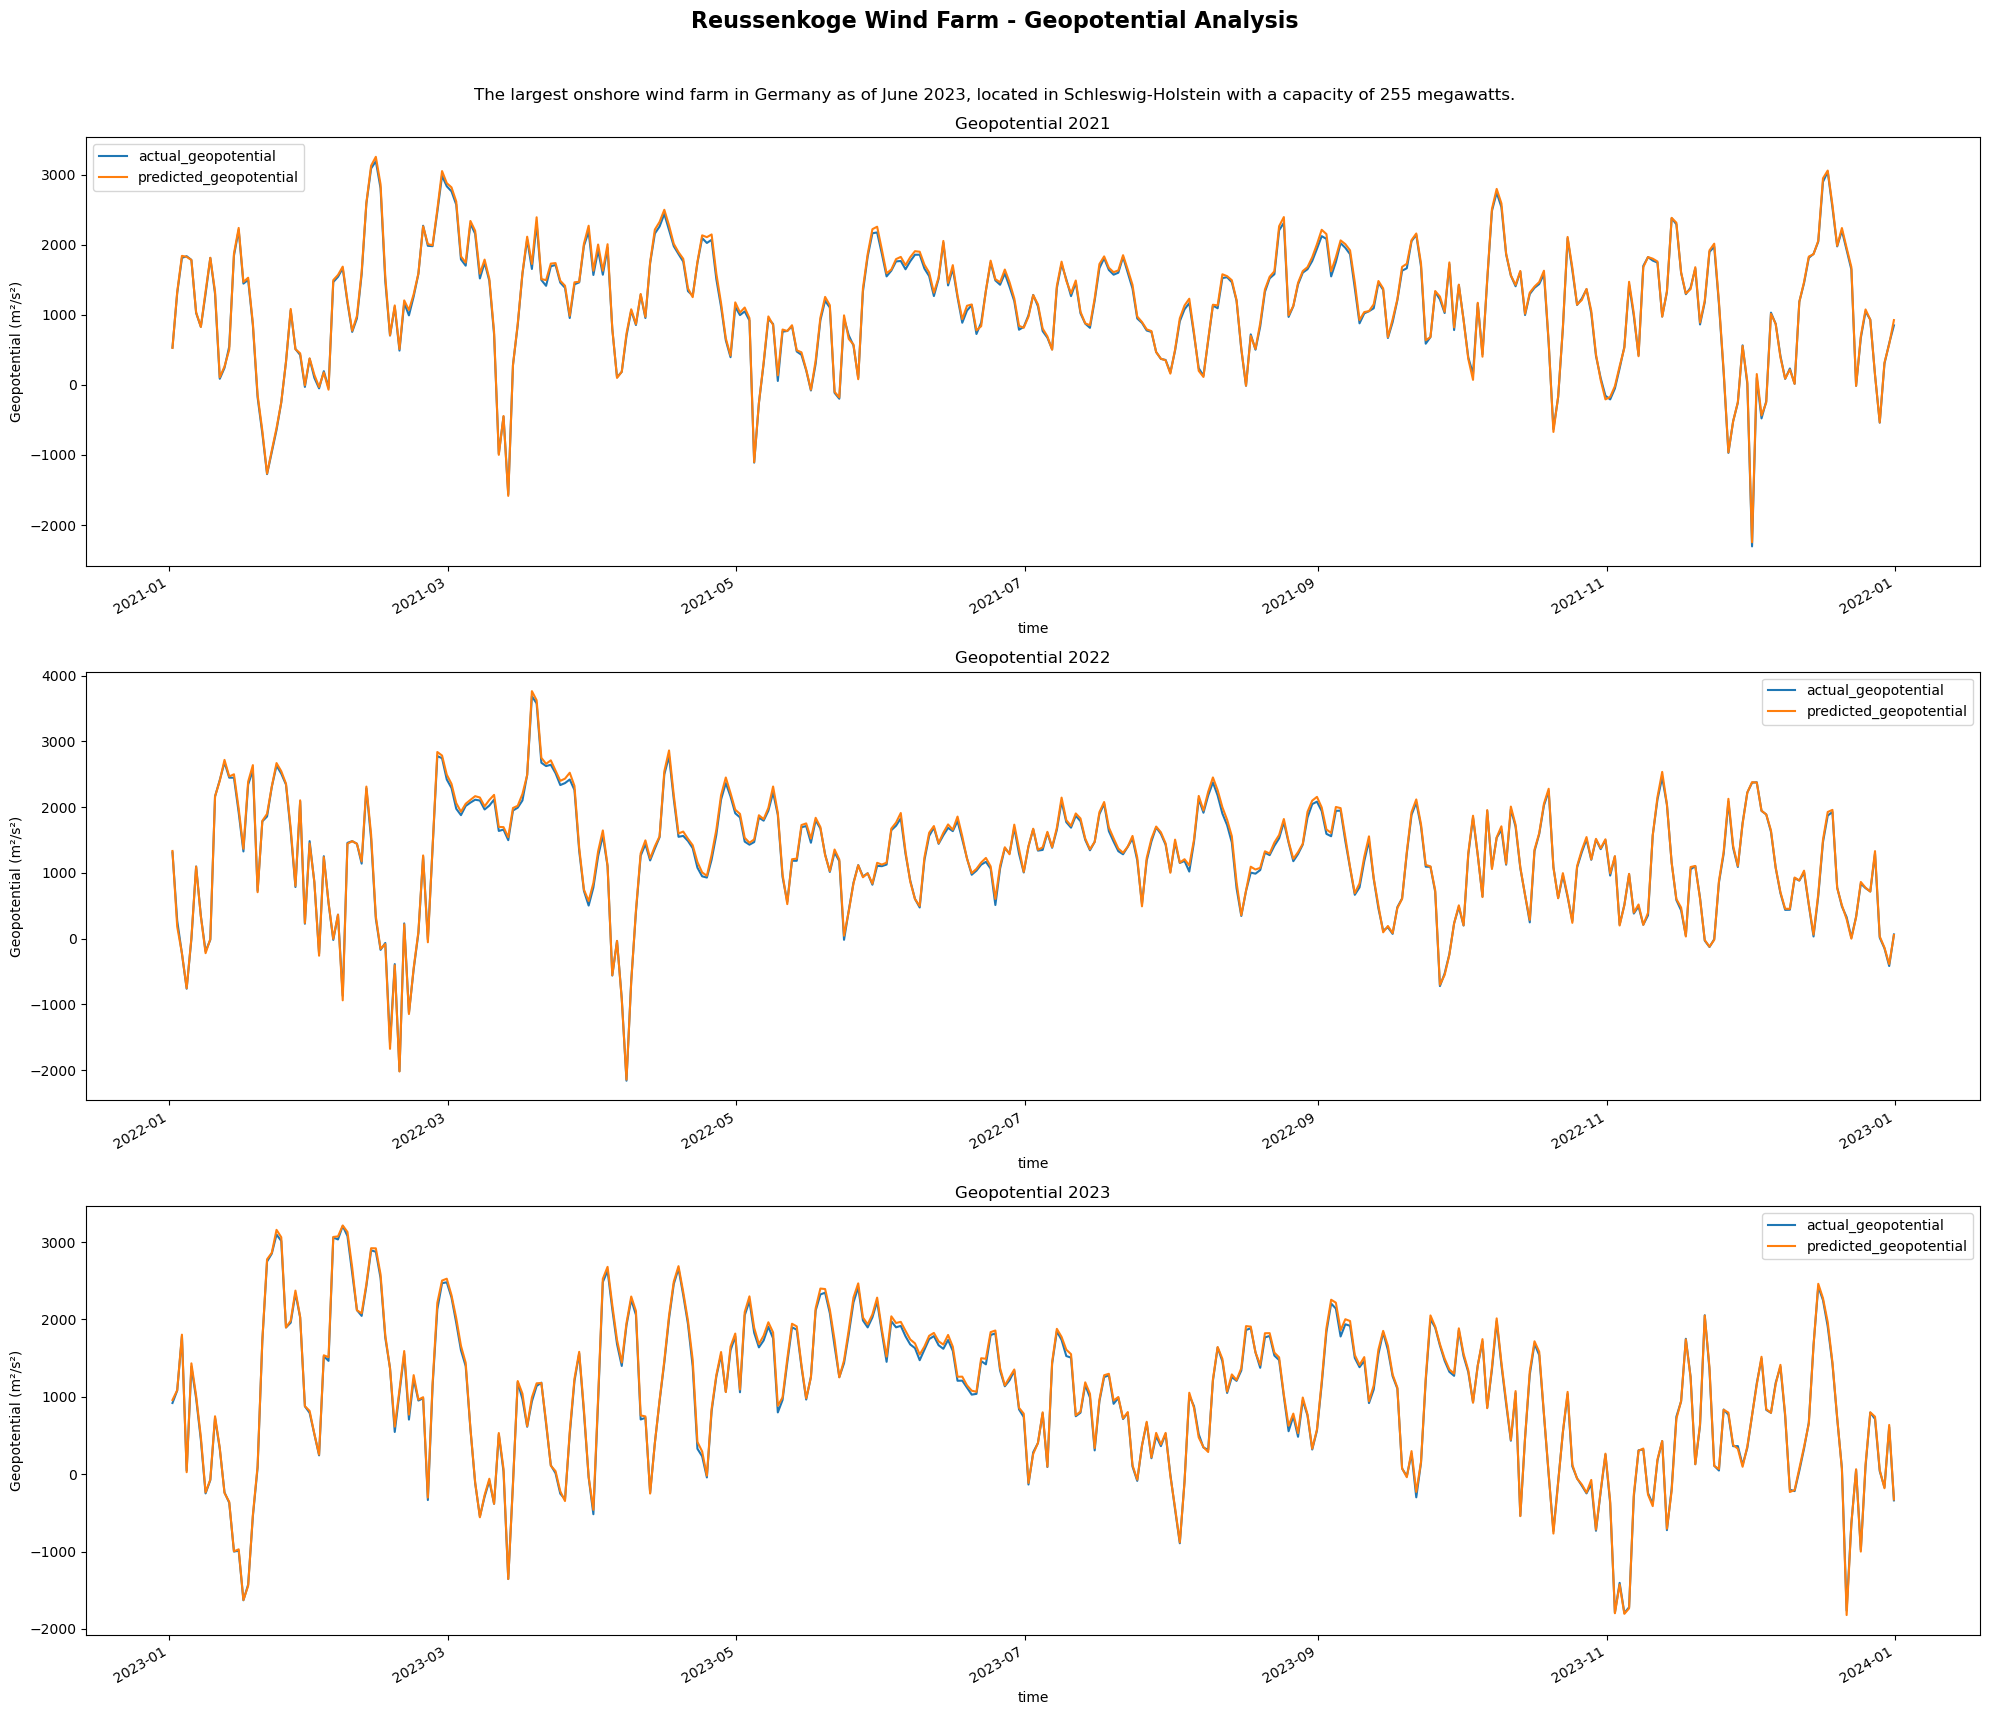

In [225]:
import matplotlib.pyplot as plt

# Set up a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 18))  # Increased height to accommodate the title block

# Add a main title with information about the wind farm
fig.suptitle('Reussenkoge Wind Farm - Geopotential Analysis', fontsize=16, fontweight='bold')
plt.figtext(0.5, 0.93, 'The largest onshore wind farm in Germany as of June 2023, located in Schleswig-Holstein with a capacity of 255 megawatts.',
            ha='center', fontsize=12)

# First subplot for 2021 geopotential
df1 = df_result.query('lat == 55 & lon == 9 & time >= "2021-01-01" & time < "2022-01-01"')
df1_grouped = df1.groupby('time').agg({
    'actual_geopotential': 'mean',
    'predicted_geopotential': 'mean'
})
df1_grouped.plot(ax=axs[0], title='Geopotential 2021')
axs[0].set_ylabel('Geopotential (m²/s²)')

# Second subplot for 2022 geopotential
df2 = df_result.query('lat == 55 & lon == 9 & time >= "2022-01-01" & time < "2023-01-01"')
df2_grouped = df2.groupby('time').agg({
    'actual_geopotential': 'mean',
    'predicted_geopotential': 'mean'
})
df2_grouped.plot(ax=axs[1], title='Geopotential 2022')
axs[1].set_ylabel('Geopotential (m²/s²)')

# Third subplot for 2023 geopotential
df3 = df_result.query('lat == 55 & lon == 9 & time >= "2023-01-01" & time < "2024-01-01"')
df3_grouped = df3.groupby('time').agg({
    'actual_geopotential': 'mean',
    'predicted_geopotential': 'mean'
})
df3_grouped.plot(ax=axs[2], title='Geopotential 2023')
axs[2].set_ylabel('Geopotential (m²/s²)')

# Adjust layout to accommodate the main title and subtitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


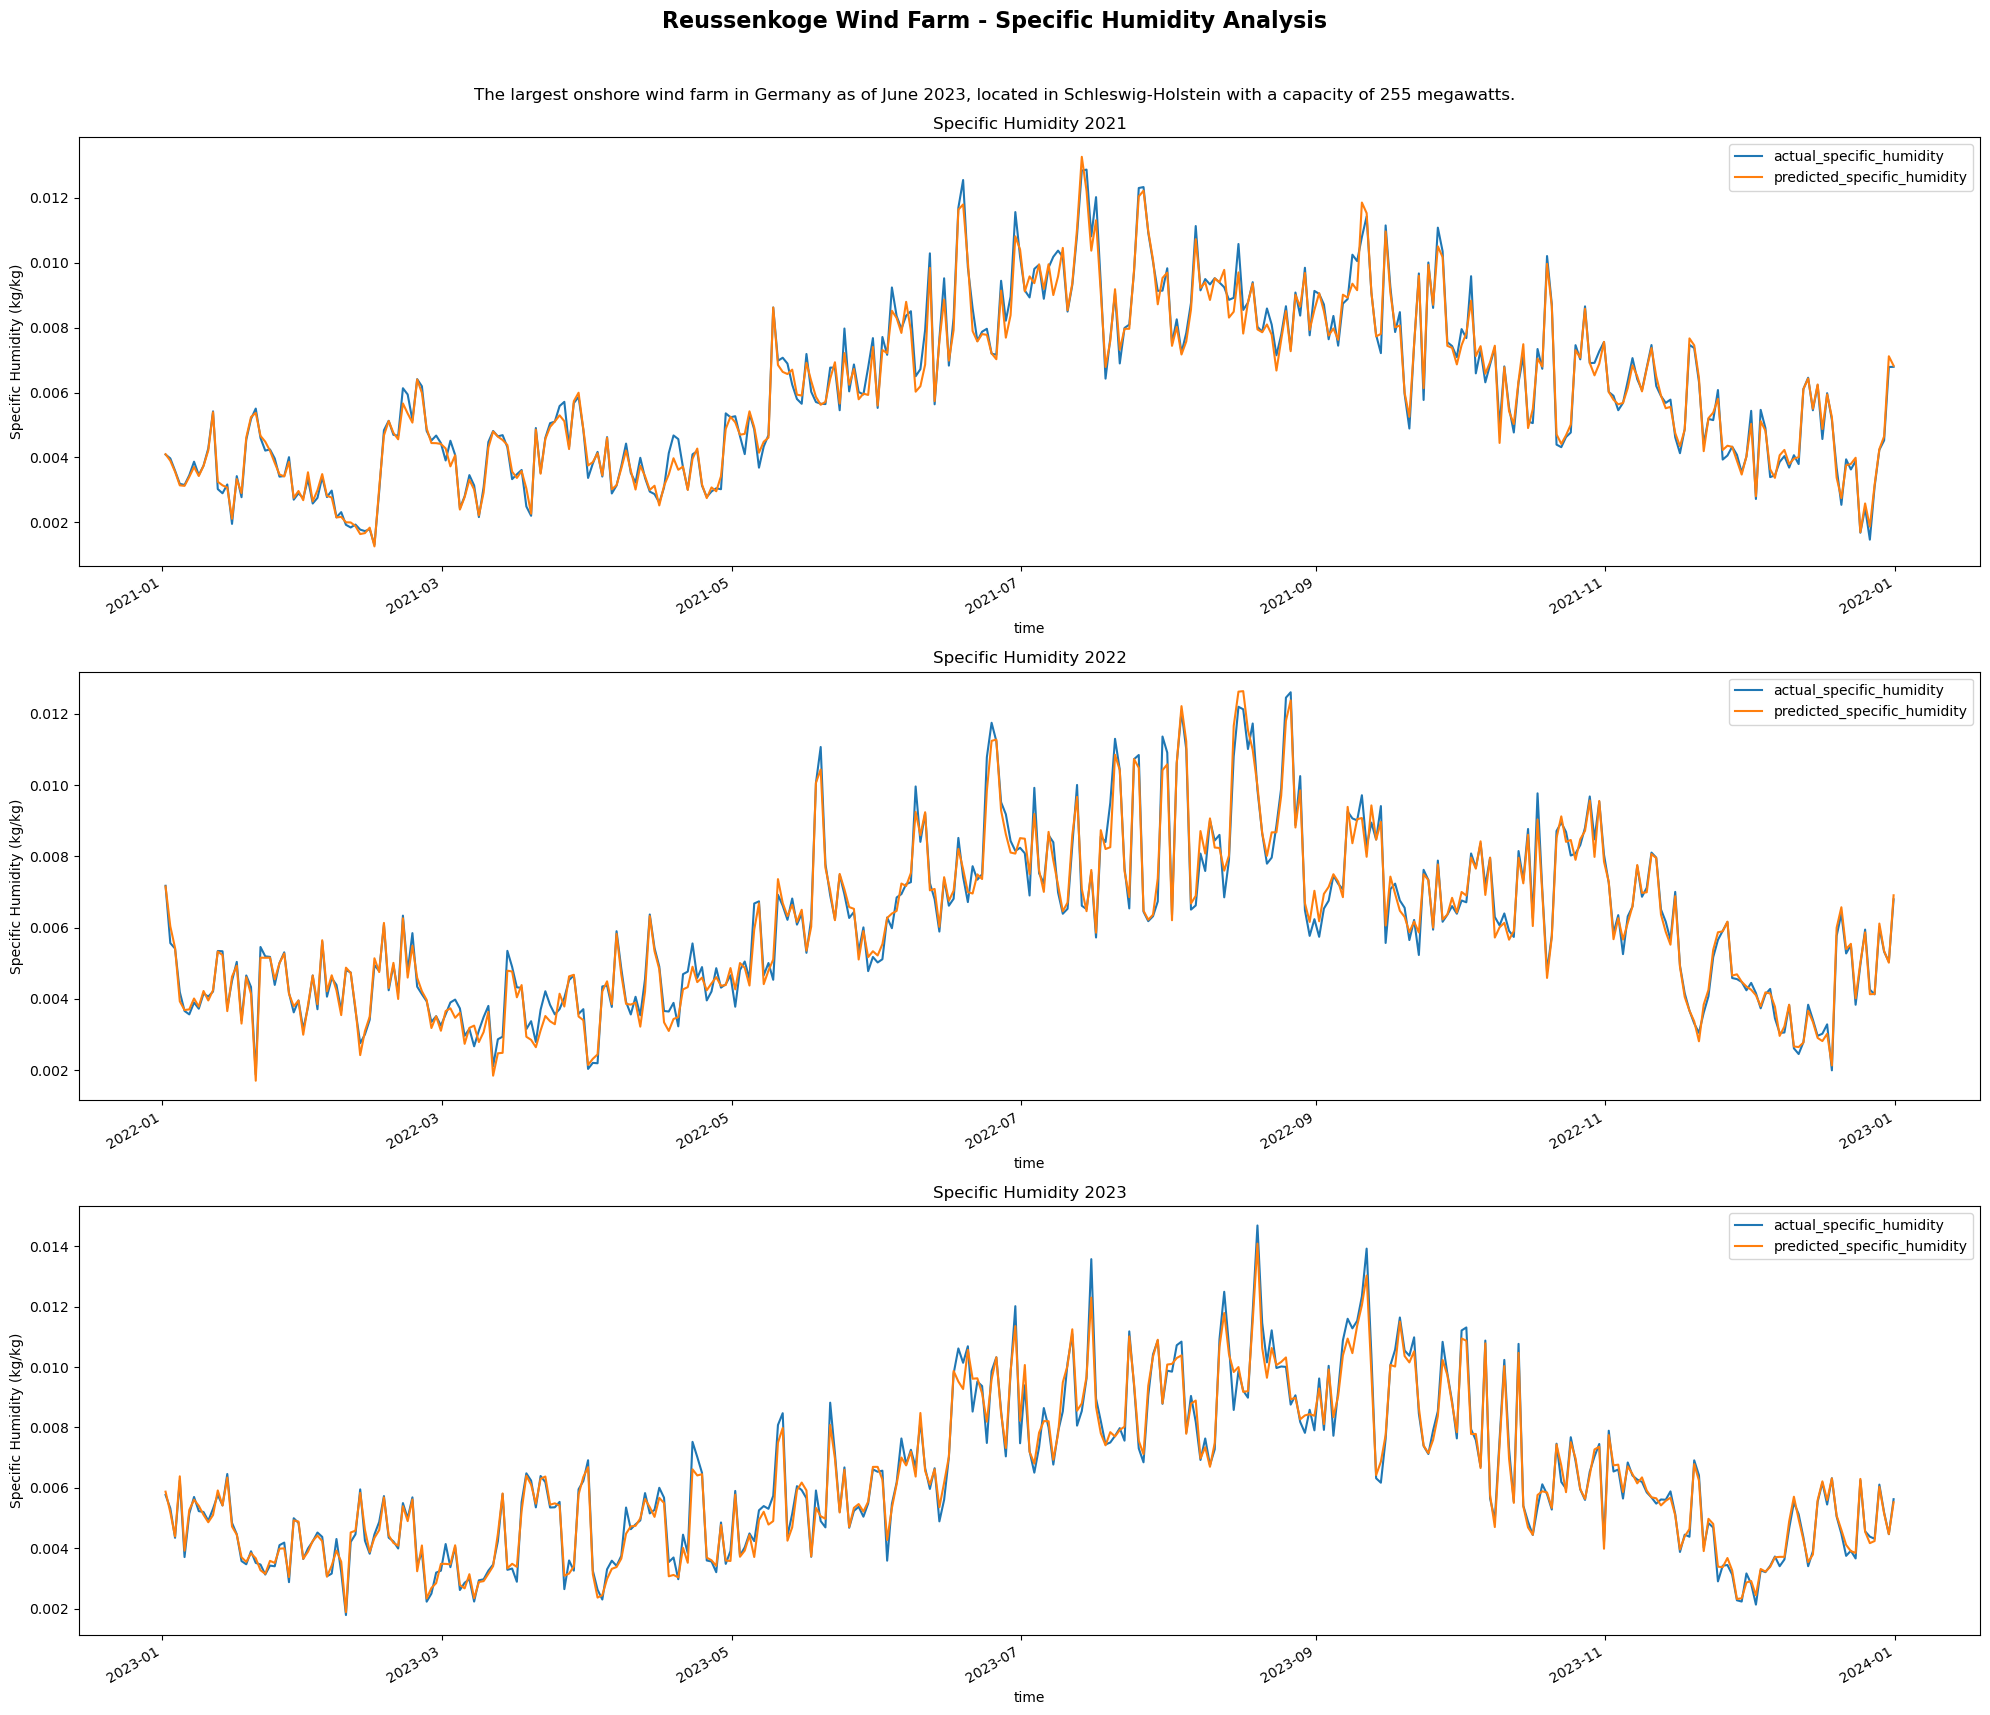

In [230]:
import matplotlib.pyplot as plt

# Set up a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(20, 18))  # Increased height to accommodate the title block

# Add a main title with information about the wind farm
fig.suptitle('Reussenkoge Wind Farm - Specific Humidity Analysis', fontsize=16, fontweight='bold')
plt.figtext(0.5, 0.93, 'The largest onshore wind farm in Germany as of June 2023, located in Schleswig-Holstein with a capacity of 255 megawatts.',
            ha='center', fontsize=12)

# First subplot for 2021 specific humidity
df1 = df_result.query('lat == 55 & lon == 9 & time >= "2021-01-01" & time < "2022-01-01"')
df1_grouped = df1.groupby('time').agg({
    'actual_specific_humidity': 'mean',
    'predicted_specific_humidity': 'mean'
})
df1_grouped.plot(ax=axs[0], title='Specific Humidity 2021')
axs[0].set_ylabel('Specific Humidity (kg/kg)')

# Second subplot for 2022 specific humidity
df2 = df_result.query('lat == 55 & lon == 9 & time >= "2022-01-01" & time < "2023-01-01"')
df2_grouped = df2.groupby('time').agg({
    'actual_specific_humidity': 'mean',
    'predicted_specific_humidity': 'mean'
})
df2_grouped.plot(ax=axs[1], title='Specific Humidity 2022')
axs[1].set_ylabel('Specific Humidity (kg/kg)')

# Third subplot for 2023 specific humidity
df3 = df_result.query('lat == 55 & lon == 9 & time >= "2023-01-01" & time < "2024-01-01"')
df3_grouped = df3.groupby('time').agg({
    'actual_specific_humidity': 'mean',
    'predicted_specific_humidity': 'mean'
})
df3_grouped.plot(ax=axs[2], title='Specific Humidity 2023')
axs[2].set_ylabel('Specific Humidity (kg/kg)')

# Adjust layout to accommodate the main title and subtitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plot
plt.show()


In [229]:
df_result

,time,actual_geopotential,actual_specific_humidity,actual_temperature,actual_wind_speed,lat,lon,predicted_wind_speed,predicted_geopotential,predicted_temperature,predicted_specific_humidity
160,2021-01-01 18:00:00,479.991577,0.004732,279.725403,4.041633,55.0,6.0,3.888828,512.89570,279.44610,0.004712
161,2021-01-01 18:00:00,473.938354,0.004806,279.232269,1.477065,55.0,7.0,2.297869,491.44916,279.07358,0.004694
162,2021-01-01 18:00:00,507.133423,0.004494,276.909698,3.336156,55.0,8.0,1.208886,499.87897,277.75180,0.004548
163,2021-01-01 18:00:00,534.470581,0.004090,275.052704,0.963249,55.0,9.0,0.567350,527.89075,275.02023,0.004100
164,2021-01-01 18:00:00,535.056274,0.003912,275.214783,1.136661,55.0,10.0,1.466734,531.13910,274.95510,0.003944
...,...,...,...,...,...,...,...,...,...,...,...
360235,2024-01-31 18:00:00,2668.913574,0.004480,284.192963,2.131998,48.0,11.0,1.675533,2705.95950,283.30597,0.004204
360236,2024-01-31 18:00:00,2650.558594,0.004667,284.177429,1.427392,48.0,12.0,1.599633,2694.76120,282.94600,0.004039
360237,2024-01-31 18:00:00,2644.505371,0.004425,283.615326,1.443183,48.0,13.0,1.720269,2693.54400,282.61774,0.003905
360238,2024-01-31 18:00:00,2643.724121,0.004084,282.948059,1.223305,48.0,14.0,1.637455,2683.46360,282.33240,0.003883
